In [1]:
# Build the map

from collections import deque
import string
import numpy as np

# Load input into appropriate data structures
_LUT = {k:v for k, v in zip(string.ascii_lowercase, range(26))}
_temp = deque()
with open('../inputs/day12-input') as f:
    i = 0
    flag = False
    while True:
        c = f.read(1)
        match c:
            case '':  # EOF
                break
            case '\n': # EOL
                if not flag:
                    _cols = i
                    flag = True
                continue
            case 'S':
                start_pos = i
                _temp.append(_LUT['a'])
                i += 1
            case 'E':
                end_pos = i
                _temp.append(_LUT['z'])
                i += 1
            case _:
                _temp.append(_LUT[c])
                i += 1
grid = np.array(_temp).reshape(len(_temp) // _cols, _cols)
start_pos = (start_pos // _cols, start_pos % _cols)
end_pos = (end_pos // _cols, end_pos % _cols)
_temp.clear()
del _temp, _cols, _LUT

# Pad the grid so numpy plays nice when I ask for all neighbors of nodes on the map edge
grid = np.pad(grid, 1, constant_values=27)
start_pos = (start_pos[0] + 1, start_pos[1] + 1)
end_pos = (end_pos[0] + 1, end_pos[1] + 1)


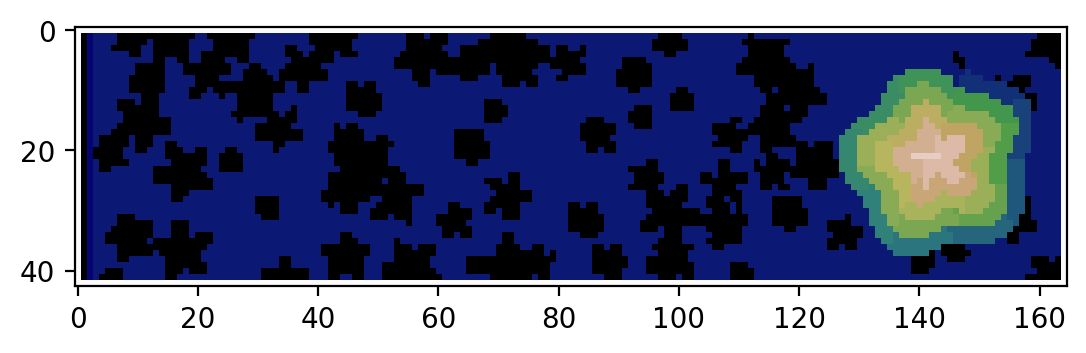

In [2]:
# Plotting stuff to debug and compare algos

import matplotlib as mpl
import matplotlib.pyplot as plt

def scale_plot_size(factor=1.5):
    default_dpi = mpl.rcParamsDefault['figure.dpi']
    mpl.rcParams['figure.dpi'] = default_dpi*factor

scale_plot_size(2)

fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.grid(visible=False)
ax.imshow(grid, cmap='gist_earth')

Steps: 534


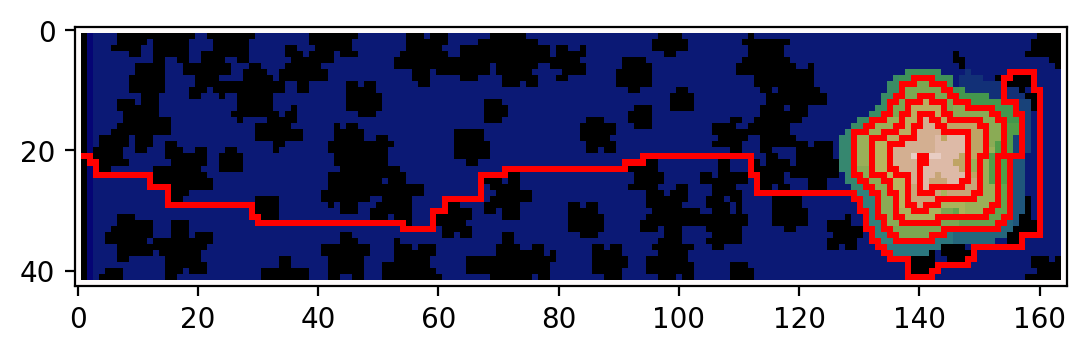

In [3]:
# My solution

def neighbors(g: np.ndarray, p: tuple) -> list:
    """Filter obstacles before returning list"""
    ret = []
    for d in [(1, 0), (0, 1), (-1, 0), (0, -1)]:
        node = (p[0] + d[0], p[1] + d[1])
        if g[node] <= g[p] + 1:
            ret.append(node)
    return ret


def mdist(a: tuple, b: tuple) -> int:
    """Manhattan distance"""
    d = abs(a[0] - b[0]) + abs(a[1] - b[1])
    return d

# Naive A* pathfinding
debug = False
i = 0
start_h = mdist(start_pos, end_pos)
fringe = {start_pos: (start_pos, 0, start_h, start_h)}  # (r, c): (ante, g, h, f)
visited = {}
while True:
    pos = sorted(fringe, key=lambda k: fringe[k][3])[0]  # Sort fringe by f-value
    visited[pos] = fringe.pop(pos)
    if debug:
        print(f'{i}: {pos}')
        i += 1
    if pos == end_pos:
        break
    for n in neighbors(grid, pos):
        if n in visited:
            continue
        h = mdist(n, end_pos)
        g = visited[pos][1] + 1
        n_attrs = (pos, g, h, g + h)
        try:
            if n_attrs[3] < fringe[n][3]:  # compare f, keep lower
                fringe[n] = n_attrs
        except KeyError:  # New node (not in dict)
            fringe[n] = n_attrs

# Rebuild path
path = deque()
while pos != start_pos:
    pos = visited[pos][0]
    path.append(pos)
print(f'Steps: {len(path)}')

# Plot path for debugging
overlay = np.zeros_like(grid)
for p in path:
    overlay[p] = 1
ax.imshow(overlay, cmap=mpl.colors.ListedColormap(['#00000000', 'r']))
fig


534


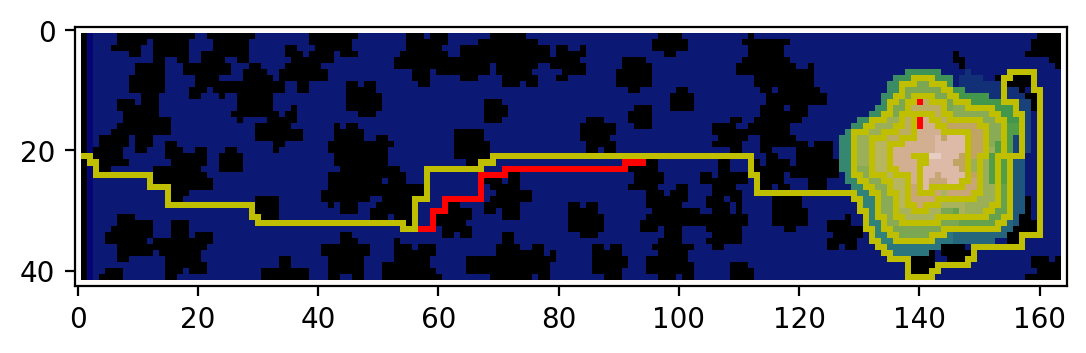

In [4]:
# Code from https://github.com/Jelly-Pudding/ with edits; used for comp when I got wrong answers

lst = []

with open("../inputs/day12-input") as f:
    for line in f:
        line = line.strip()
        lst.append([])
        for idx in range(len(line)):
            lst[-1].append(line[idx])
            if line[idx] == "S":
                start = (len(lst) - 1, idx)
                lst[-1][-1] = "a"
            elif line[idx] == "E":
                end = (len(lst) - 1, idx)
                lst[-1][-1] = "z"

def get_possible_moves(coords_x, coords_y):
    moves = []
    # up?
    if coords_x - 1 >= 0:  # If upward position isn't off the edge of the grid...
        if ord(lst[coords_x][coords_y]) - 96 + 1 >= ord(lst[coords_x - 1][coords_y]) - 96:
            moves.append((coords_x - 1, coords_y))
    # down?
    if coords_x + 1 <= len(lst) - 1:
        if ord(lst[coords_x][coords_y]) - 96 + 1 >= ord(lst[coords_x + 1][coords_y]) - 96:
            moves.append((coords_x + 1, coords_y))
    # right ?
    if coords_y + 1 <= len(lst[coords_x]) - 1:
        if ord(lst[coords_x][coords_y]) - 96 + 1 >= ord(lst[coords_x][coords_y + 1]) - 96:
            moves.append((coords_x, coords_y + 1))
    # left ?
    if coords_y - 1 >= 0:
        if ord(lst[coords_x][coords_y]) - 96 + 1 >= ord(lst[coords_x][coords_y - 1]) - 96:
            moves.append((coords_x, coords_y - 1))
    return moves

def manhattan_distance(node):
    h = abs(node[0] - end[0]) + abs(node[1] - end[1])
    return h

def a_star():
    path = []
    open_list = []
    closed_list = []
    open_list.append({"pos": start, "parent": None, "g_value": 0, "f_value": 0})
    while open_list:
        # Find node w/ min f-val in open list, move to closed list
        min_f_node = min(open_list, key=lambda x:x["f_value"])
        current_i = next((i for (i, d) in enumerate(open_list) if d["pos"] == min_f_node["pos"]), None)  # Get node's index in open list
        open_list.pop(current_i)
        closed_list.append(min_f_node)

        # Get new moves from this node
        children = get_possible_moves(min_f_node["pos"][0], min_f_node["pos"][1])
        for child in children:
            parent = min_f_node["pos"]
            child_g = min_f_node["g_value"] + 1
            child_f = child_g + manhattan_distance(child)
            if child == end:
                path.append(child)
                path.append(parent)
                parent = min_f_node["parent"]
                while parent is not None:
                    path.append(parent)
                    parent_closed_i = next((i for (i, d) in enumerate(closed_list) if d["pos"] == parent), None)
                    if parent_closed_i is None:
                        parent = None
                    else:
                        parent = closed_list[parent_closed_i]["parent"]
                return path[::-1]

            child_closed_i = next((i for (i, d) in enumerate(closed_list) if d["pos"] == child), None)
            if child_closed_i is not None:
                continue
            child_open_i = next((i for (i, d) in enumerate(open_list) if d["pos"] == child), None)
            if child_open_i is None:
                open_list.append({"pos": child, "parent": parent, "g_value": child_g, "f_value": child_f})
            elif child_f >= open_list[child_open_i]["f_value"]:
                continue
            child_open_i = next((i for (i, d) in enumerate(open_list) if d["pos"] == child), None)
            open_list[child_open_i] = {"pos": child, "parent": parent, "g_value": child_g, "f_value": child_f}

path2 = a_star()
print(len(path2) - 1)

# Plot path for debugging
overlay2 = np.zeros_like(grid)
for p in path2:
    p = tuple([_ + 1 for _ in p]) # Accommodate the boundary I added to the grid
    overlay2[p] = 1
ax.imshow(overlay2, cmap=mpl.colors.ListedColormap(['#00000000', 'y']))
fig
